In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import Tensor
from torch.nn import functional as F
from torch.profiler import profile, record_function, ProfilerActivity

from tomopt.muon import MuonBatch, generate_batch
from tomopt.volume import PassiveLayer, VoxelDetectorLayer, Volume
from tomopt.optimisation import VoxelVolumeWrapper, DetectorLoss, PassiveYielder, NoMoreNaNs, VoxelMetricLogger
from tomopt.inference import VoxelScatterBatch, VoxelX0Inferer
from tomopt.core import X0

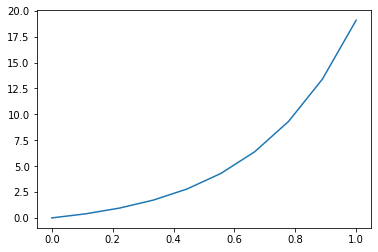

In [3]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))  # free for negative efficiency, sharp rise as efficiency increases

x = torch.linspace(0,1,10)
plt.plot(x, eff_cost(x))

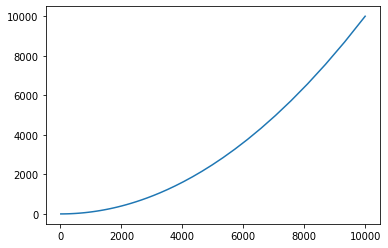

In [4]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2  # free for negative resoltuion, gradual rise as resoltuion increases

x = torch.logspace(1,4,100)
plt.plot(x, res_cost(x))

In [5]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [6]:
def profile_func(func, name, profs, sort):
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as profs[name]:
        with record_function(name):
            val = func()

    print(profs[name].key_averages(group_by_input_shape=True).table(sort_by=sort, row_limit=10))
    return val

# CPU

In [7]:
DEVICE = torch.device('cpu')

In [8]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(VoxelDetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res, device=DEVICE,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size, device=DEVICE))

    return nn.ModuleList(layers) 

In [9]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): VoxelDetectorLayer()
    (1): VoxelDetectorLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PassiveLayer()
    (8): VoxelDetectorLayer()
    (9): VoxelDetectorLayer()
  )
)

## Through Volume

In [34]:
muons = MuonBatch(generate_batch(100), init_z=1, device=DEVICE)

In [35]:
cpu_profs = {}

In [36]:
profile_func(partial(volume, muons), name='volume_propagation', profs=cpu_profs, sort="cpu_time_total")

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
           volume_propagation        31.67%      11.445ms        99.91%      36.111ms      36.111ms             1  
                  aten::index         7.49%       2.707ms        11.92%       4.309ms      33.664us           128  
                    aten::mul         6.94%       2.510ms        11.14%       4.027ms      13.075us           308  
                 aten::select         7.77%       2.810ms         8.79%       3.176ms       5.514us           576  
                  aten::slice         7.31%       2.641ms         8.18%       2.957ms       6.542us           452  
                     aten::to         4.09%       1.480ms         6.93% 

## Scatter inference

In [37]:
sb = profile_func(partial(VoxelScatterBatch, mu=muons, volume=volume), name='scatter_inference', profs=cpu_profs, sort="cpu_time_total")

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
            scatter_inference        24.46%       2.087ms        99.67%       8.503ms       8.503ms             1  
                  aten::slice        11.41%     973.000us        12.50%       1.066ms       7.107us           150  
                    aten::cat         1.79%     153.000us         9.58%     817.000us      26.355us            31  
                    aten::mul         6.39%     545.000us         7.97%     680.000us      20.000us            34  
                   aten::_cat         5.10%     435.000us         7.78%     664.000us      21.419us            31  
                  aten::index         5.01%     427.000us         7.02% 

In [38]:
n = 'location_unc'
with profile(activities=[ProfilerActivity.CPU]) as cpu_profs[n]:
    with record_function(n):
        sb.location_unc

print(cpu_profs[n].key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

----------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                              Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
----------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      location_unc         1.76%      35.437ms       100.00%        2.008s        2.008s             1  
                      aten::matmul         7.71%     154.885ms        60.06%        1.206s     150.137us          8032  
            aten::_index_put_impl_        13.75%     276.196ms        35.62%     715.208ms      44.700us         16000  
                   InverseBackward         0.04%     894.000us        33.42%     671.147ms      41.947ms            16  
                     IndexBackward         0.04%     826.000us        23.67%     475.375ms       7.428ms            64  
                         aten::m

In [39]:
n = 'dtheta_unc'
with profile(activities=[ProfilerActivity.CPU]) as cpu_profs[n]:
    with record_function(n):
        sb.dtheta_unc

print(cpu_profs[n].key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 dtheta_unc         3.28%      33.190ms        99.99%        1.012s        1.012s             1  
     aten::_index_put_impl_        23.51%     237.855ms        59.77%     604.676ms      56.575us         10688  
              IndexBackward         0.08%     849.000us        40.14%     406.138ms       6.346ms            64  
                  aten::mul        13.67%     138.287ms        27.41%     277.339ms     187.138us          1482  
               aten::select        14.33%     144.995ms        15.97%     161.597ms       5.519us         29280  
             SWhereBackward         0.03%     340.000us        14.57%     147.419ms     

In [40]:
n = 'theta_in_unc'
with profile(activities=[ProfilerActivity.CPU]) as cpu_profs[n]:
    with record_function(n):
        sb.theta_in_unc

print(cpu_profs[n].key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
               theta_in_unc         3.18%       7.669ms        99.99%     241.275ms     241.275ms             1  
     aten::_index_put_impl_        26.49%      63.925ms        63.67%     153.640ms      57.500us          2672  
              IndexBackward         0.09%     216.000us        42.96%     103.664ms       6.479ms            16  
                  aten::mul        13.45%      32.447ms        26.99%      65.133ms     181.429us           359  
               aten::select        14.40%      34.743ms        16.10%      38.858ms       5.308us          7320  
             SWhereBackward         0.04%      85.000us        14.72%      35.514ms     

In [41]:
n = 'theta_out_unc'
with profile(activities=[ProfilerActivity.CPU]) as cpu_profs[n]:
    with record_function(n):
        sb.theta_out_unc

print(cpu_profs[n].key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
              theta_out_unc         2.95%       7.321ms        99.99%     247.806ms     247.806ms             1  
     aten::_index_put_impl_        25.43%      63.031ms        62.90%     155.892ms      58.343us          2672  
              IndexBackward         0.09%     218.000us        42.80%     106.067ms       6.629ms            16  
                  aten::mul        13.21%      32.741ms        26.53%      65.743ms     183.128us           359  
               aten::select        15.34%      38.025ms        17.03%      42.213ms       5.767us          7320  
             SWhereBackward         0.04%      87.000us        15.53%      38.477ms     

## X0 Inference

In [42]:
x0_inferer = VoxelX0Inferer(scatters=sb)

In [43]:
x0_inferer.mask

tensor([ True, False,  True,  True, False, False,  True,  True,  True, False,
         True,  True,  True,  True, False,  True, False, False,  True, False,
         True,  True,  True, False, False,  True,  True,  True, False,  True,
         True,  True,  True, False,  True, False, False, False, False,  True,
        False,  True,  True, False,  True, False,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True, False,  True, False, False,
        False,  True,  True, False, False,  True, False, False, False,  True,
         True,  True, False, False,  True,  True, False, False, False,  True,
        False,  True,  True])

In [44]:
profile_func(x0_inferer.x0_from_dtheta, name='x0_inf', profs=cpu_profs, sort="cpu_time_total")

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       x0_inf        45.68%       6.207ms        99.81%      13.562ms      13.562ms             1  
                    aten::mul        14.68%       1.995ms        26.32%       3.576ms      24.162us           148  
                 PowBackward0         0.96%     130.000us         8.69%       1.181ms     131.222us             9  
                 MulBackward0         1.74%     237.000us         7.83%       1.064ms      44.333us            24  
           ReciprocalBackward         0.75%     102.000us         5.00%     680.000us      75.556us             9  
                    aten::eye         1.29%     175.000us         4.65% 

(tensor([0.0008, 0.0022, 0.0056, 0.0008, 0.0054, 0.0075, 0.0021, 0.0019, 0.0006,
         0.0127, 0.0010, 0.0019, 0.0006, 0.0044, 0.0010, 0.0016, 0.0037, 0.0032,
         0.0025, 0.0035, 0.0012, 0.0045, 0.0030, 0.0011, 0.0054, 0.0033, 0.0015,
         0.0035, 0.0020, 0.0007, 0.0099, 0.0038, 0.0048, 0.0017, 0.0007, 0.0024,
         0.0043, 0.0046, 0.0093, 0.0071, 0.0020, 0.0011, 0.0005, 0.0028, 0.0008,
         0.0008, 0.0007, 0.0026], dtype=torch.float64, grad_fn=<MulBackward0>),
 tensor([0.0005, 0.0023, 0.0097, 0.0005, 0.0091, 0.0143, 0.0022, 0.0019, 0.0003,
         0.0326, 0.0007, 0.0019, 0.0003, 0.0067, 0.0007, 0.0015, 0.0052, 0.0042,
         0.0029, 0.0047, 0.0010, 0.0070, 0.0039, 0.0009, 0.0092, 0.0044, 0.0013,
         0.0047, 0.0021, 0.0004, 0.0229, 0.0055, 0.0076, 0.0016, 0.0005, 0.0027,
         0.0065, 0.0071, 0.0208, 0.0139, 0.0021, 0.0009, 0.0003, 0.0035, 0.0005,
         0.0005, 0.0004, 0.0030], dtype=torch.float64, grad_fn=<SqrtBackward>))

In [45]:
pred, weight = profile_func(x0_inferer.pred_x0, name='pred_passive', profs=cpu_profs, sort="cpu_time_total")

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 pred_passive        29.34%     313.993ms       100.00%        1.070s        1.070s             1  
                    aten::mul        12.92%     138.272ms        13.96%     149.419ms      20.321us          7353  
                    aten::add         5.41%      57.939ms        10.03%     107.344ms      25.491us          4211  
                     aten::eq         4.78%      51.132ms         7.72%      82.562ms      11.448us          7212  
                    aten::sub         6.34%      67.883ms         7.06%      75.495ms      13.975us          5402  
                    aten::all         5.31%      56.777ms         6.31% 

## Loss

In [46]:
loss_func = DetectorLoss(cost_coef=0)

In [47]:
loss_val = profile_func(partial(loss_func, pred_x0=pred, pred_weight=weight, volume=volume), name='loss_calc', profs=cpu_profs, sort="cpu_time_total")

-----------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------  ------------  ------------  ------------  ------------  ------------  ------------  
              loss_calc        33.75%     723.000us        98.46%       2.109ms       2.109ms             1  
              aten::sum         8.59%     184.000us         9.99%     214.000us      23.778us             9  
             aten::relu         6.12%     131.000us         9.94%     213.000us      26.625us             8  
              aten::pow         7.10%     152.000us         9.76%     209.000us      41.800us             5  
               aten::to         4.76%     102.000us         8.45%     181.000us      10.647us            17  
              aten::div         4.62%      99.000us         7.98%     171.000us      34.200us             5  
          

In [48]:
loss_val = profile_func(loss_val.backward, name='loss_backward', profs=cpu_profs, sort="cpu_time_total")

-----------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                               Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      loss_backward        17.03%     265.949ms       100.00%        1.562s        1.562s             1  
                          aten::mul        20.34%     317.596ms        26.13%     408.142ms      12.714us         32101  
                        ErfBackward         4.48%      69.994ms        20.67%     322.820ms      89.672us          3600  
                       SubBackward0         2.62%      40.911ms        17.96%     280.481ms      51.816us          5413  
                          aten::neg         9.61%     150.045ms        15.35%     239.721ms       9.469us         25316  
                      Pr

In [10]:
%%timeit
muons = MuonBatch(generate_batch(100), init_z=1, device=DEVICE)
volume(muons)
sb = VoxelScatterBatch(muons, volume)
x0_inferer = VoxelX0Inferer(scatters=sb)
pred, weight = x0_inferer.pred_x0()
loss_func = DetectorLoss(cost_coef=0)
loss_val = loss_func(pred_x0=pred, pred_weight=weight, volume=volume)
loss_val.backward()

2.1 s ± 100 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
passives = PassiveYielder([arb_rad_length])

In [12]:
wrapper = VoxelVolumeWrapper(volume,
                             res_opt=partial(torch.optim.SGD, lr=2e9),  # Scale of resolution is large, so use high LR
                             eff_opt=partial(torch.optim.SGD, lr=2e4),  # Scale of efficiency is [0,1] so use smaller LR
                             loss_func=DetectorLoss(cost_coef=None))  # Loss is precision + cost_coef*detector cost, balance coef as required or leave as None to automatically balance on first batch

In [13]:
_ = wrapper.fit(n_epochs=1,
                passive_bs=1,
                n_mu_per_volume=1000,
                mu_bs=100,
                trn_passives=passives,
                val_passives=passives,
                cbs=[])